In [32]:
!pip install feature_engine

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as pt
import matplotlib.pyplot as plt
import seaborn as sns
from feature_engine.outliers import ArbitraryOutlierCapper

from sklearn.linear_model import LinearRegression,Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from pickle import dump

import warnings
warnings.filterwarnings("ignore")

Load Dataset

In [34]:
df = pd.read_csv("/content/insurance.csv")
print(df)

      age     sex     bmi  children smoker     region      charges
0      19  female  27.900         0    yes  southwest  16884.92400
1      18    male  33.770         1     no  southeast   1725.55230
2      28    male  33.000         3     no  southeast   4449.46200
3      33    male  22.705         0     no  northwest  21984.47061
4      32    male  28.880         0     no  northwest   3866.85520
...   ...     ...     ...       ...    ...        ...          ...
1333   50    male  30.970         3     no  northwest  10600.54830
1334   18  female  31.920         0     no  northeast   2205.98080
1335   18  female  36.850         0     no  southeast   1629.83350
1336   21  female  25.800         0     no  southwest   2007.94500
1337   61  female  29.070         0    yes  northwest  29141.36030

[1338 rows x 7 columns]


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [36]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [37]:
df.isnull().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


**EXPLORATORY DATA ANALYSIS**

Distribution Analysis Of Categorical Features

The data is approximately equally distributed between 'sex' and 'region' features. However, the data in the 'smoker' feature exhibits class imbalance with 1,064 non-smokers (79.52%) versus 274 smokers (20.48%).

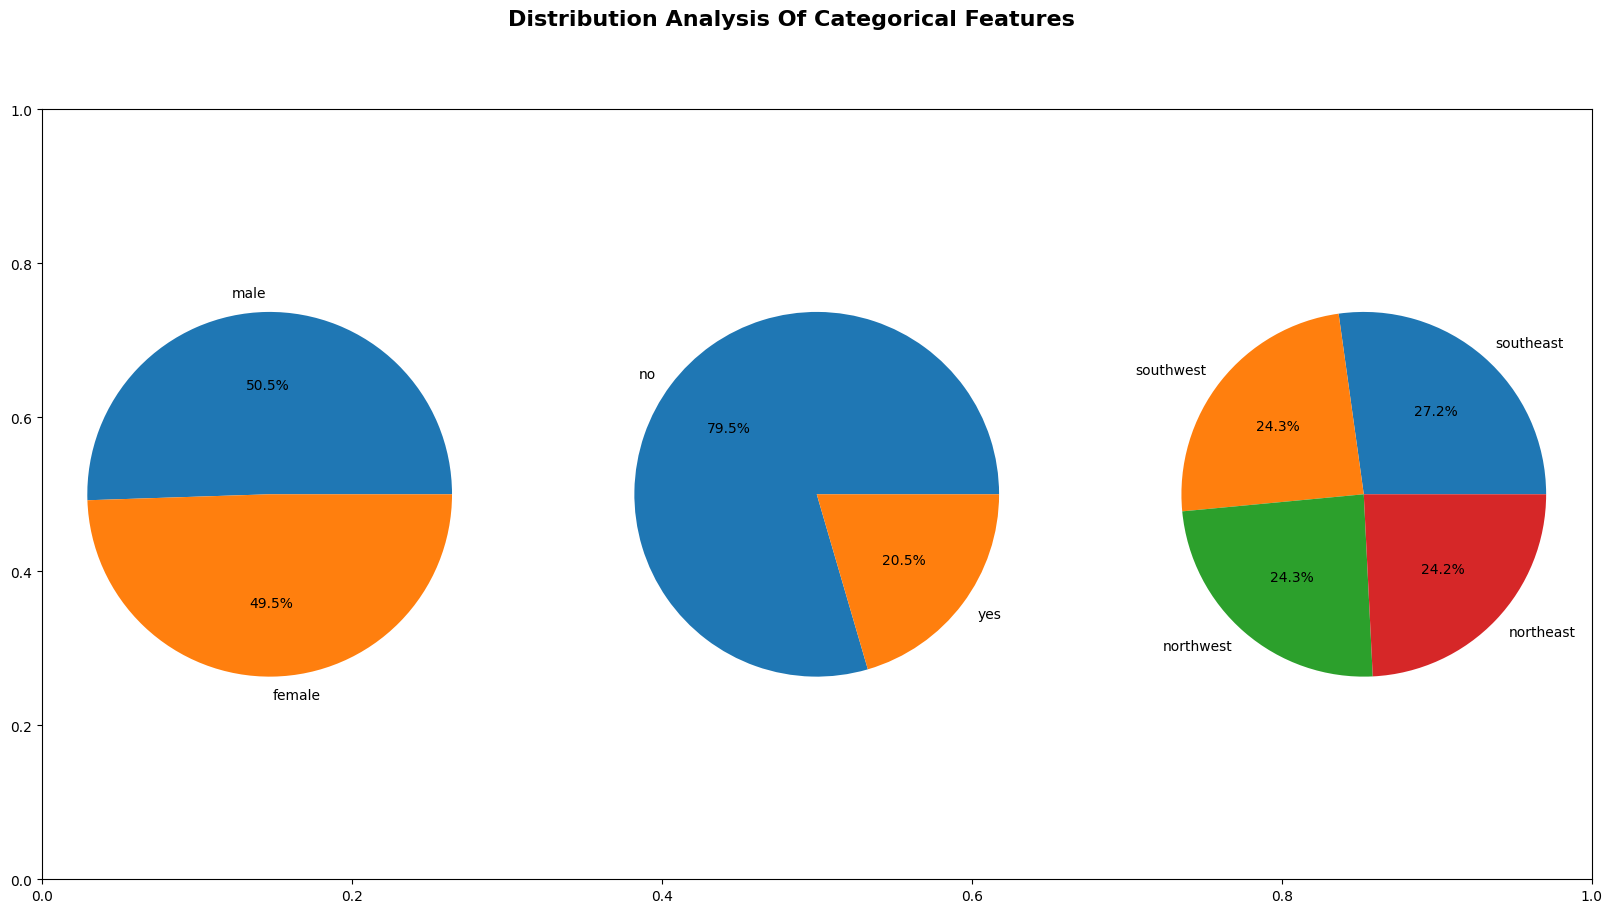

In [38]:
features = ['sex', 'smoker', 'region']
fig, axes = plt.subplots(figsize = (20, 10))
fig.suptitle('Distribution Analysis Of Categorical Features', fontsize = 16, fontweight = 'bold')

for i, col in enumerate(features):
    plt.subplot(1, 3, i + 1)

    x = df[col].value_counts()
    plt.pie(x.to_numpy(), labels = x.index.tolist(), autopct = '%1.1f%%')

plt.show()

Distribution Analysis Of Numerical Features

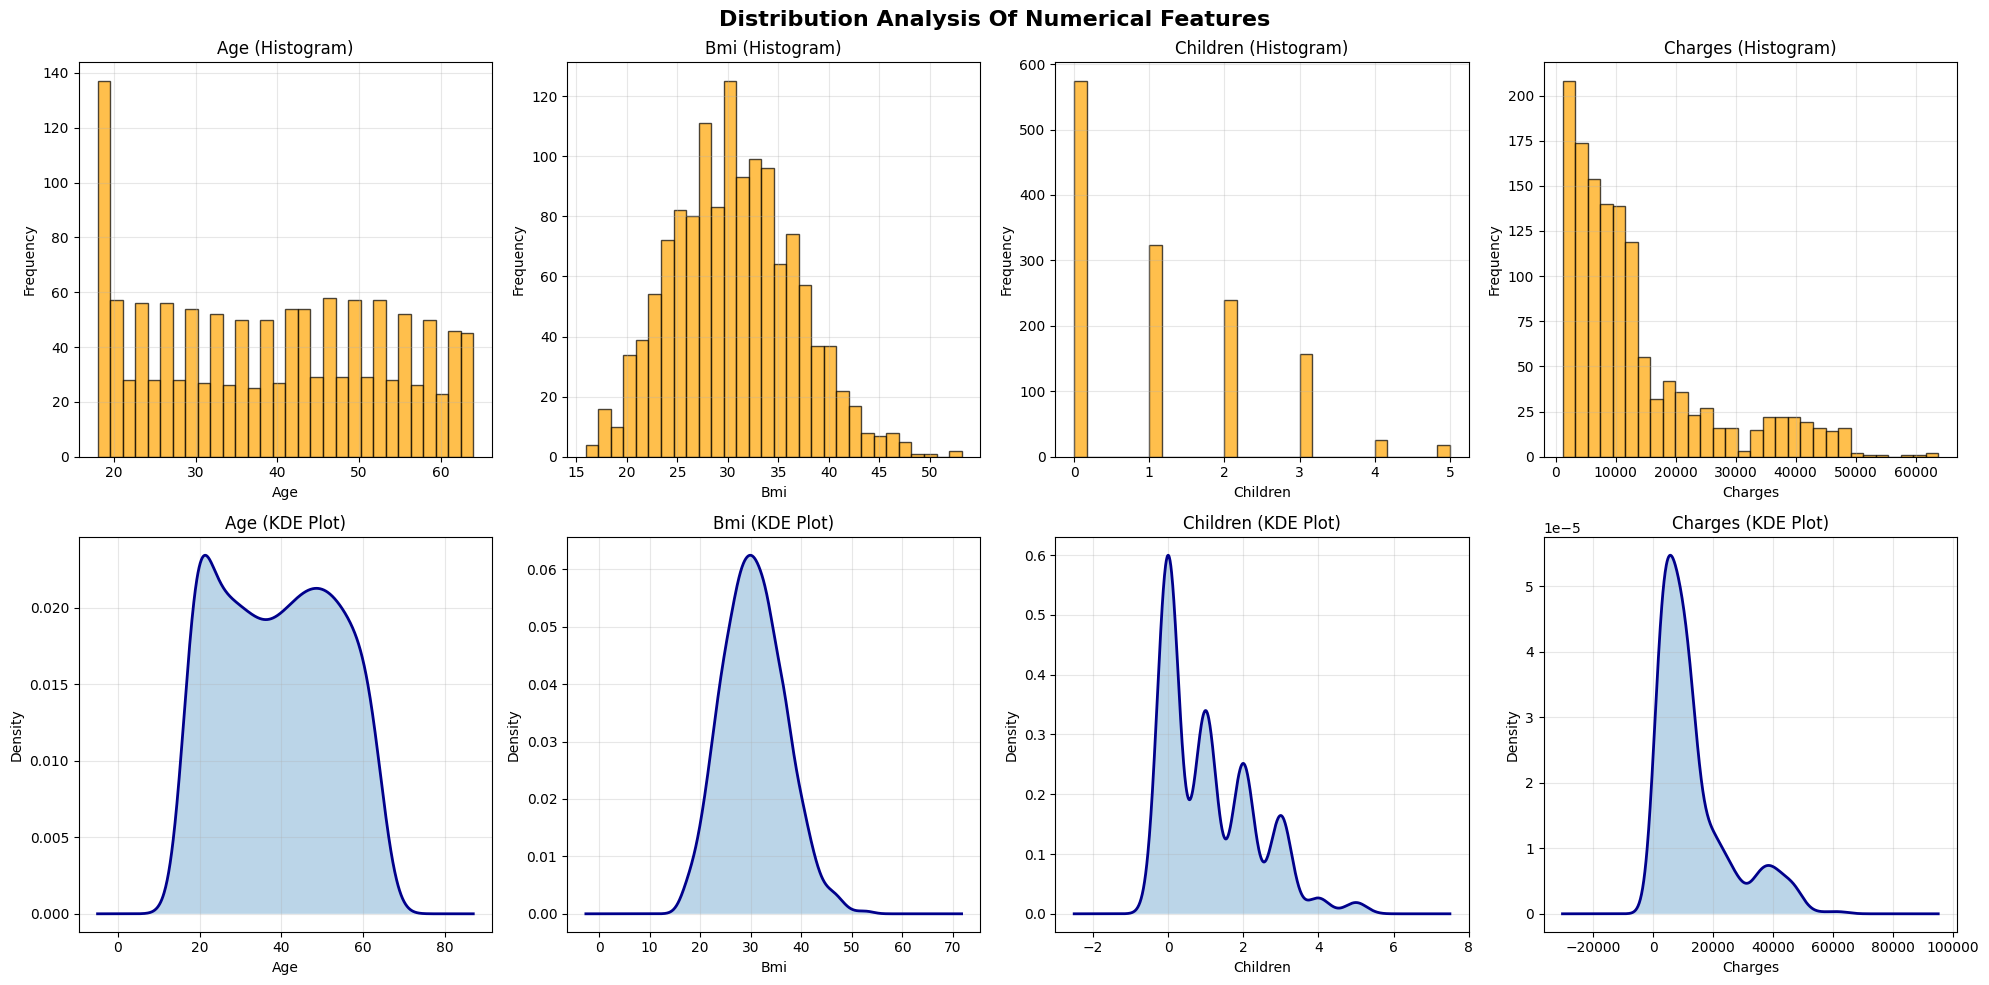

In [39]:
numerical_features = ['age', 'bmi', 'children', 'charges']

fig, axes = plt.subplots(2, 4, figsize = (20, 10))
fig.suptitle('Distribution Analysis Of Numerical Features', fontsize = 16, fontweight = 'bold')

for idx, feature in enumerate(numerical_features):
    ax1 = axes[0, idx]
    ax1.hist(df[feature], bins=30, edgecolor = 'black', alpha = 0.7, color = 'orange')
    ax1.set_xlabel(feature.capitalize())
    ax1.set_ylabel('Frequency')
    ax1.set_title(f'{feature.capitalize()} (Histogram)')
    ax1.grid(True, alpha=0.3)

    ax2 = axes[1, idx]
    df[feature].plot(kind = 'kde', ax = ax2, color = 'darkblue', linewidth = 2)
    ax2.set_xlabel(feature.capitalize())
    ax2.set_ylabel('Density')
    ax2.set_title(f'{feature.capitalize()} (KDE Plot)')
    ax2.grid(True, alpha = 0.3)
    ax2.fill_between(ax2.lines[0].get_xdata(), ax2.lines[0].get_ydata(), alpha = 0.3)

plt.tight_layout()
plt.show()

- Charges are slightly higher for males as compared to females.
- The premium amount charged to smokers is around 3x that of non-smokers.
- Charges are approximately the same in the 4 regions

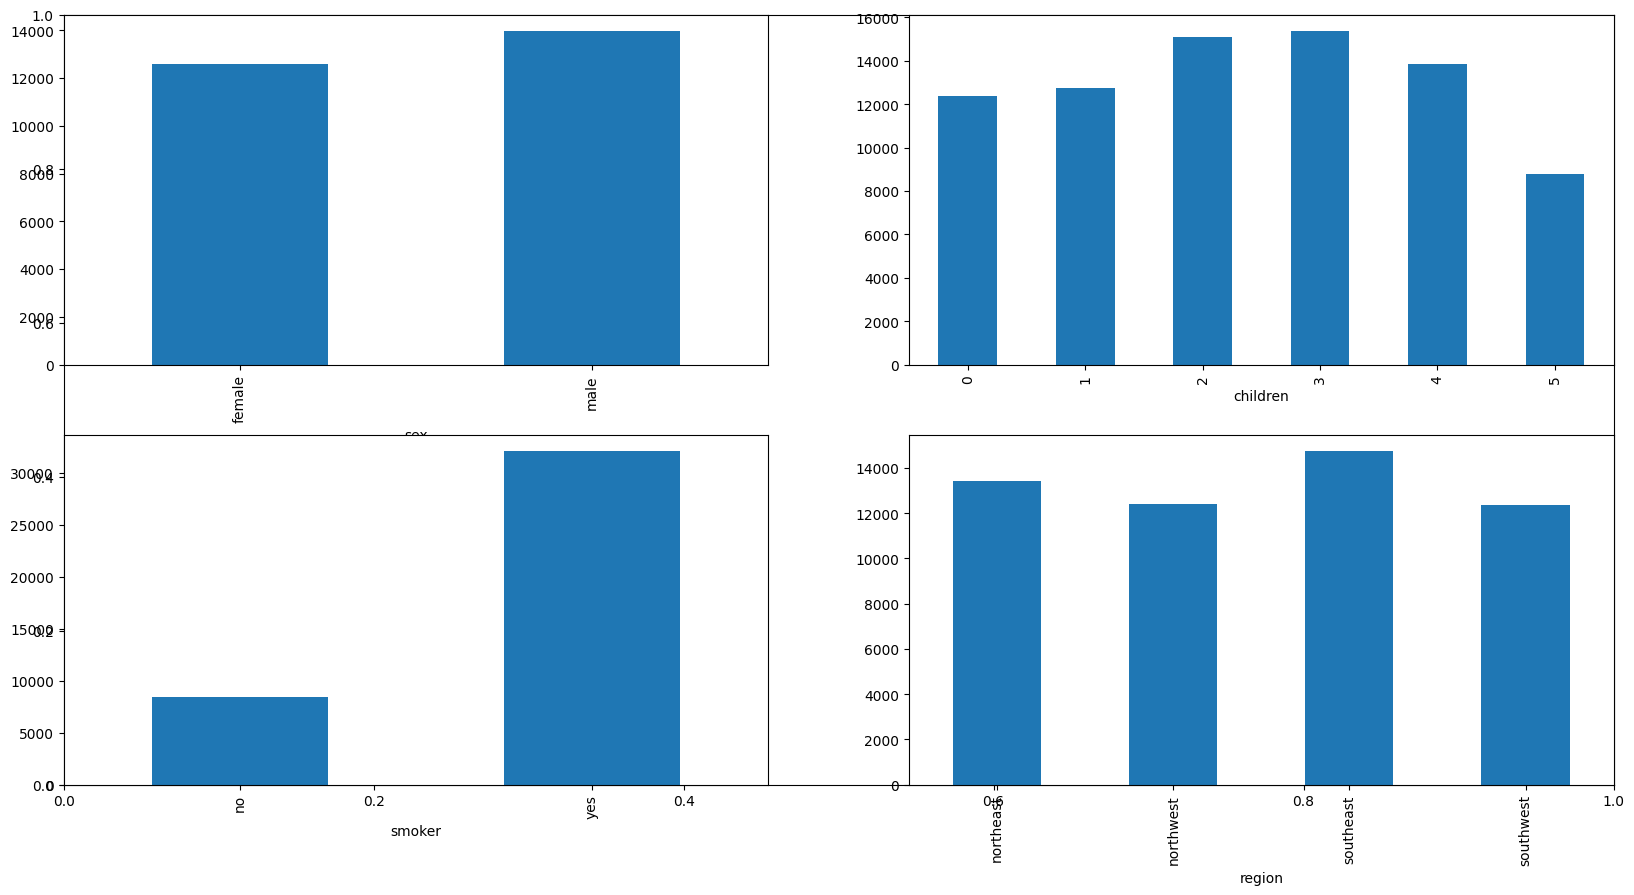

In [40]:
features = ['sex', 'children', 'smoker', 'region']

plt.subplots(figsize=(20, 10))
for i, col in enumerate(features):
    plt.subplot(2, 2, i + 1)
    df.groupby(col)['charges'].mean().astype(float).plot.bar()

plt.show()

The plots exhibit:
- Clear distinction between the charges paid by smokers.
- The premium amount goes up as the age of a person increases.

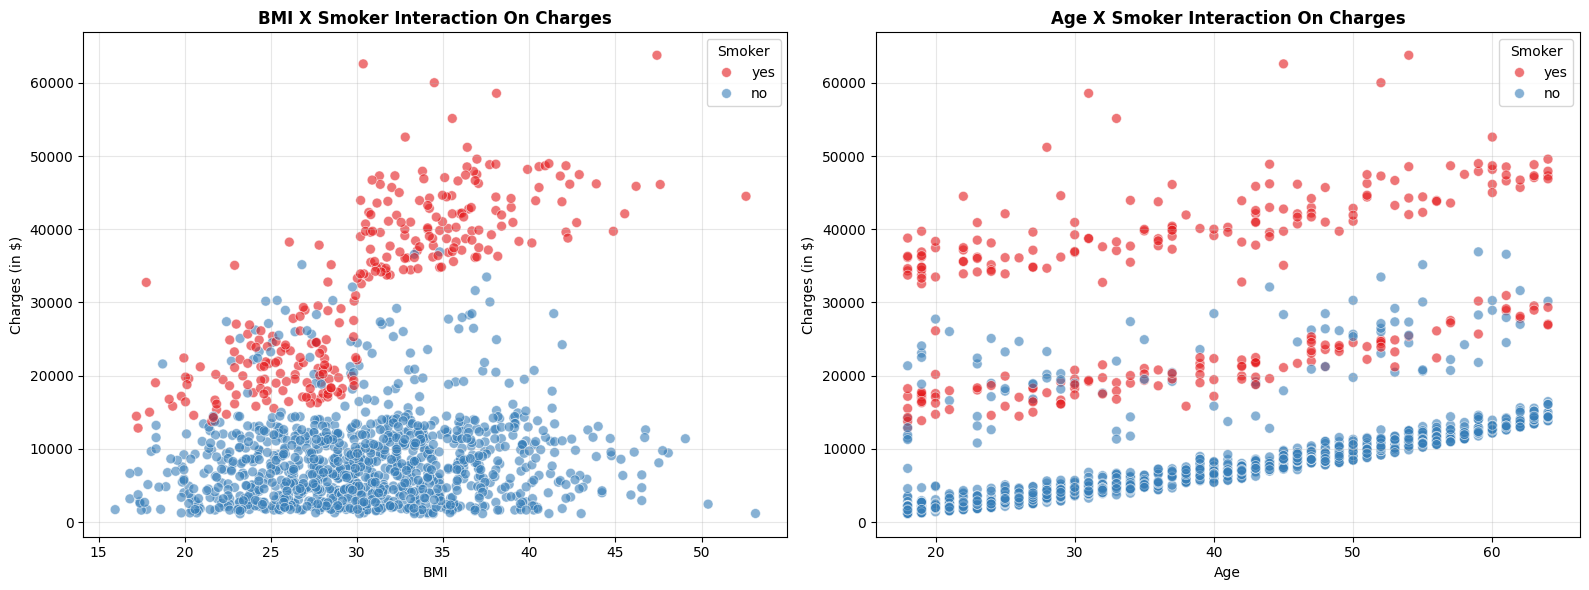

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.scatterplot(data=df, x='bmi', y='charges', hue='smoker', palette='Set1', alpha=0.6, s=50, ax=axes[0])
axes[0].set_title('BMI X Smoker Interaction On Charges', fontweight='bold')
axes[0].set_xlabel('BMI')
axes[0].set_ylabel('Charges (in $)')
axes[0].legend(title='Smoker')
axes[0].grid(True, alpha=0.3)

sns.scatterplot(data=df, x='age', y='charges', hue='smoker', palette='Set1', alpha=0.6, s=50, ax=axes[1])
axes[1].set_title('Age X Smoker Interaction On Charges', fontweight='bold')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Charges (in $)')
axes[1].legend(title='Smoker')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**DATA PREPROCESSING**

No outliers are present in the 'age' column.

<Axes: ylabel='age'>

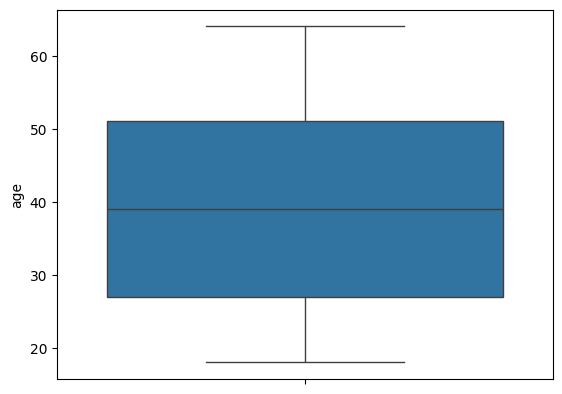

In [42]:
df.drop_duplicates(inplace = True)
sns.boxplot(df['age'])

Outliers present in 'bmi' column

<Axes: ylabel='bmi'>

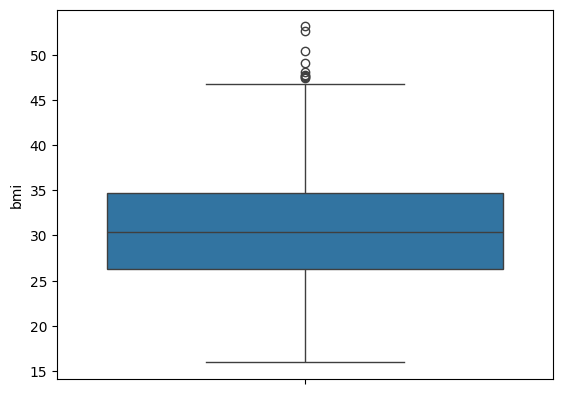

In [43]:
sns.boxplot(df['bmi'])

In [44]:
Q1 = df['bmi'].quantile(0.25)
Q2 = df['bmi'].quantile(0.5)
Q3 = df['bmi'].quantile(0.75)
iqr = Q3-Q1
lowlim = Q1-1.5*iqr
upplim = Q3+1.5*iqr

print(f"Lower Limit: {lowlim}")
print(f"Lower Limit: {upplim}")

Lower Limit: 13.674999999999994
Lower Limit: 47.31500000000001


<Axes: ylabel='bmi'>

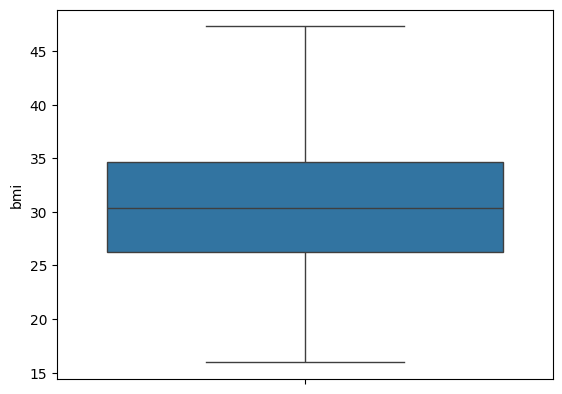

In [45]:
arb = ArbitraryOutlierCapper(min_capping_dict = {'bmi':13.6749}, max_capping_dict = {'bmi':47.315})
df[['bmi']] = arb.fit_transform(df[['bmi']])
sns.boxplot(df['bmi'])

Data Wrangling

Data in 'age' and 'bmi' approximately follows normal distribution.

In [46]:
df['bmi'].skew()
df['age'].skew()

np.float64(0.054780773126998195)

Encoding

In [47]:
df['sex'] = df['sex'].map({'male': 0, 'female': 1})
df['smoker'] = df['smoker'].map({'yes': 1, 'no': 0})
df['region'] = df['region'].map({'northwest': 0, 'northeast': 1, 'southeast': 2, 'southwest': 3})

print(df)

      age  sex     bmi  children  smoker  region      charges
0      19    1  27.900         0       1       3  16884.92400
1      18    0  33.770         1       0       2   1725.55230
2      28    0  33.000         3       0       2   4449.46200
3      33    0  22.705         0       0       0  21984.47061
4      32    0  28.880         0       0       0   3866.85520
...   ...  ...     ...       ...     ...     ...          ...
1333   50    0  30.970         3       0       0  10600.54830
1334   18    1  31.920         0       0       1   2205.98080
1335   18    1  36.850         0       0       2   1629.83350
1336   21    1  25.800         0       0       3   2007.94500
1337   61    1  29.070         0       1       0  29141.36030

[1337 rows x 7 columns]


In [48]:
df.corr()

,age,sex,bmi,children,smoker,region,charges
age,1.000000,0.019814,0.111998,0.041536,-0.025587,0.001771,0.298308
sex,0.019814,1.000000,-0.044831,-0.017848,-0.076596,-0.008998,-0.058044
bmi,0.111998,-0.044831,1.000000,0.013692,0.003151,0.156937,0.199063
children,0.041536,-0.017848,0.013692,1.000000,0.007331,-0.002842,0.067389
smoker,-0.025587,-0.076596,0.003151,0.007331,1.000000,0.012736,0.787234
region,0.001771,-0.008998,0.156937,-0.002842,0.012736,1.000000,0.010767
charges,0.298308,-0.058044,0.199063,0.067389,0.787234,0.010767,1.000000


**MODEL TRAINING**

In [49]:
X = df.drop(['charges'], axis = 1)
Y = df[['charges']]

l1 = []
l2 = []
l3 = []
cvs = 0

for i in range(40, 50):
 xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size = 0.2, random_state = i)
 lrmodel = LinearRegression()
 lrmodel.fit(xtrain,ytrain)
 l1.append(lrmodel.score(xtrain, ytrain))
 l2.append(lrmodel.score(xtest, ytest))
 cvs = (cross_val_score(lrmodel, X, Y, cv = 5)).mean()
 l3.append(cvs)

df1 = pd.DataFrame({'Train Accuracy':l1, 'Test Accuracy':l2, 'Cross Validation Score':l3})
print(df1)

   Train Accuracy  Test Accuracy  Cross Validation Score
0        0.741659       0.778409                 0.74707
1        0.756401       0.706267                 0.74707
2        0.729542       0.806239                 0.74707
3        0.754260       0.732791                 0.74707
4        0.742966       0.779591                 0.74707
5        0.753281       0.731769                 0.74707
6        0.741261       0.776456                 0.74707
7        0.731940       0.796173                 0.74707
8        0.751915       0.741742                 0.74707
9        0.756348       0.722565                 0.74707


In [50]:
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size = 0.2, random_state = 42)

Testing Different ML Algorithms

1) Linear Regression

In [51]:
lrmodel = LinearRegression()
lrmodel.fit(xtrain, ytrain)

print("Train Accuracy:", lrmodel.score(xtrain, ytrain))
print("Test Accuracy:", lrmodel.score(xtest, ytest))
print("Cross Validation Score", cross_val_score(lrmodel, X, Y, cv = 5).mean())

Train Accuracy: 0.7295415541376445
Test Accuracy: 0.8062391115570589
Cross Validation Score 0.7470697972809902


2. Support Vector Regression

In [52]:
svrmodel = SVR()
svrmodel.fit(xtrain, ytrain)
ypredtrain1 = svrmodel.predict(xtrain)
ypredtest1 = svrmodel.predict(xtest)

print("Train R2:", r2_score(ytrain, ypredtrain1))
print("Test R2:", r2_score(ytest, ypredtest1))
print("Cross Validation R2:", cross_val_score(svrmodel, X, Y, cv = 5).mean())

Train R2: -0.10151474302536445
Test R2: -0.1344454720199666
Cross Validation R2: -0.10374591327267262


3. Random Forest Regression

In [53]:
rfmodel = RandomForestRegressor(random_state = 42)
rfmodel.fit(xtrain, ytrain)
ypredtrain2 = rfmodel.predict(xtrain)
ypredtest2 = rfmodel.predict(xtest)

print("Initial Model -")
print("Train R2:", r2_score(ytrain, ypredtrain2))
print("Test R2:", r2_score(ytest, ypredtest2))
print("Cross Validation Score:", cross_val_score(rfmodel, X, Y, cv = 5).mean())

estimator = RandomForestRegressor(random_state = 42)
param_grid = {'n_estimators': [10, 40, 50, 98, 100, 120, 150]}
grid = GridSearchCV(estimator, param_grid, scoring = "r2", cv = 5)
grid.fit(xtrain, ytrain)

print("Best Parameters:", grid.best_params_)

rfmodel = RandomForestRegressor(random_state = 42, n_estimators = 120)
rfmodel.fit(xtrain, ytrain)
ypredtrain2 = rfmodel.predict(xtrain)
ypredtest2 = rfmodel.predict(xtest)

print("Tuned Model -")
print("Train R2:", r2_score(ytrain, ypredtrain2))
print("Test R2:", r2_score(ytest, ypredtest2))
print("Cross Validation Score:", cross_val_score(rfmodel, X, Y, cv = 5).mean())

Initial Model -
Train R2: 0.9738163260247533
Test R2: 0.8819423353068565
Cross Validation Score: 0.8363637309718952
Best Parameters: {'n_estimators': 120}
Tuned Model -
Train R2: 0.9746383984429655
Test R2: 0.8822009842175969
Cross Validation Score: 0.8367438097052858


4. Gradient Boosting Regression

In [54]:
gbmodel = GradientBoostingRegressor()
gbmodel.fit(xtrain, ytrain)
ypredtrain3 = gbmodel.predict(xtrain)
ypredtest3 = gbmodel.predict(xtest)

print("Initial Model -")
print("Train R2:", r2_score(ytrain, ypredtrain3))
print("Test R2:", r2_score(ytest, ypredtest3))
print("Cross Validation Score:", cross_val_score(gbmodel, X, Y, cv = 5).mean())

estimator = GradientBoostingRegressor()
param_grid = {'n_estimators': [10, 15, 19, 20, 21, 50], 'learning_rate': [0.1, 0.19, 0.2, 0.21, 0.8, 1]}
grid = GridSearchCV(estimator, param_grid, scoring = "r2", cv = 5)
grid.fit(xtrain, ytrain)

print("Best Parameters:", grid.best_params_)

gbmodel = GradientBoostingRegressor(n_estimators = 19, learning_rate = 0.2)
gbmodel.fit(xtrain, ytrain)
ypredtrain3 = gbmodel.predict(xtrain)
ypredtest3 = gbmodel.predict(xtest)

print("Tuned Model -")
print("Train R2:", r2_score(ytrain, ypredtrain3))
print("Test R2:", r2_score(ytest, ypredtest3))
print("Cross Validation Score:", cross_val_score(gbmodel, X, Y, cv = 5).mean())

Initial Model -
Train R2: 0.8931345821166041
Test R2: 0.9042609532447069
Cross Validation Score: 0.8549648675719526
Best Parameters: {'learning_rate': 0.2, 'n_estimators': 20}
Tuned Model -
Train R2: 0.8682397447116927
Test R2: 0.9017109716082661
Cross Validation Score: 0.8606041910125791


5. XGBoost

In [55]:
xgmodel = XGBRegressor()
xgmodel.fit(xtrain, ytrain)
ypredtrain4 = xgmodel.predict(xtrain)
ypredtest4 = xgmodel.predict(xtest)

print("Initial Model -")
print("Train R2:", r2_score(ytrain, ypredtrain4))
print("Test R2:", r2_score(ytest, ypredtest4))
print("Cross Validation Score:", cross_val_score(xgmodel, X, Y, cv = 5).mean())

estimator = XGBRegressor()
param_grid = {'n_estimators': [10, 15, 20, 40, 50], 'max_depth': [3, 4, 5], 'gamma': [0, 0.15, 0.3, 0.5, 1]}
grid = GridSearchCV(estimator, param_grid, scoring = "r2", cv = 5)
grid.fit(xtrain, ytrain)

print("Best Parameters:", grid.best_params_)

xgmodel = XGBRegressor(n_estimators = 15, max_depth = 3, gamma = 0)
xgmodel.fit(xtrain, ytrain)
ypredtrain4 = xgmodel.predict(xtrain)
ypredtest4 = xgmodel.predict(xtest)

print("Tuned Model -")
print("Train R2:", r2_score(ytrain, ypredtrain4))
print("Test R2:", r2_score(ytest, ypredtest4))
print("Cross Validation Score:", cross_val_score(xgmodel, X, Y, cv = 5).mean())

Initial Model -
Train R2: 0.9954123497009277
Test R2: 0.8548938035964966
Cross Validation Score: 0.8081253051757813
Best Parameters: {'gamma': 0, 'max_depth': 3, 'n_estimators': 10}
Tuned Model -
Train R2: 0.869317352771759
Test R2: 0.9022461175918579
Cross Validation Score: 0.8607115387916565


Based on the metrics, it is evident from the test that **XGBoost** performs better than the other algorithms.

Featue Importance

In [56]:
feats = pd.DataFrame(data = grid.best_estimator_.feature_importances_, index = X.columns, columns = ['Importance'])
print(feats)

          Importance
age         0.038633
sex         0.000000
bmi         0.133449
children    0.011073
smoker      0.809626
region      0.007219


In [57]:
important_features = feats[feats['Importance'] > 0.01]
print(important_features)

          Importance
age         0.038633
bmi         0.133449
children    0.011073
smoker      0.809626


Final model trained on **XGBoost** algorithmthe

In [58]:
df.drop(df[['sex', 'region']], axis = 1, inplace = True)
Xf = df.drop(df[['charges']], axis = 1)
X = df.drop(df[['charges']], axis = 1)

xtrain, xtest, ytrain, ytest = train_test_split(Xf, Y, test_size = 0.2, random_state = 42)

finalmodel = XGBRegressor(n_estimators = 15, max_depth = 3, gamma = 0)
finalmodel.fit(xtrain, ytrain)
ypredtrain4 = finalmodel.predict(xtrain)
ypredtest4 = finalmodel.predict(xtest)

print("Final Trained Model -")
print("Train R2:", r2_score(ytrain, ypredtrain4))
print("Test R2:", r2_score(ytest, ypredtest4))
print("Cross Validation Score:", cross_val_score(finalmodel, X, Y, cv = 5).mean())

Final Trained Model -
Train R2: 0.8691051602363586
Test R2: 0.9007425308227539
Cross Validation Score: 0.8606266975402832


Saving The Model

In [62]:
dump(finalmodel, open('insurancemodel.pkl', 'wb'))

Test On Unseen New Data

In [60]:
new_data = pd.DataFrame({'age': 80, 'bmi': 27.9, 'children': 0, 'smoker': 'no'}, index = [0])
new_data['smoker'] = new_data['smoker'].map({'yes': 1,'no': 0})

pred = finalmodel.predict(new_data)[0]

print(f"Predicted Medical Insurance Premium: ${pred:,.3f}")

Predicted Medical Insurance Premium: $14,164.478
